# Double Machine Learning (DML) for Observational Studies

## Workshop Overview

In this workshop, we'll explore **Double Machine Learning (DML)**, a modern causal inference method that combines machine learning with econometric theory to estimate causal effects from observational data.

### What You'll Learn:
1. **Why we need DML**: The challenges of causal inference with high-dimensional confounders
2. **Core concepts**: Orthogonalization, cross-fitting, and Neyman orthogonality
3. **Practical implementation**: Step-by-step DML using real education data
4. **Interpretation**: Understanding and presenting your results

## 1. Introduction: Why Double Machine Learning?

### The Fundamental Problem

In observational studies, we want to estimate the causal effect of a treatment (D) on an outcome (Y), but we have many confounders (X) that affect both. 

**Traditional approaches struggle when:**
- We have many confounders (high-dimensional X)
- The relationships are non-linear
- We want to use flexible ML methods but still get valid inference

**DML solves this by:**
- Using ML to flexibly control for confounders
- Maintaining valid statistical inference (confidence intervals, p-values)
- Avoiding regularization bias through orthogonalization

## 2. The Prime Membership Dataset [Synthetic Data: Only for Illustration Purposes]

We'll analyze the effect of a prime membership on 12 month spend of customers. This is a classic observational study where treatment wasn't randomly assigned.

**Key Variables:**
- **Outcome (Y)**: 12-month total spend (USD)
- **Treatment (D)**: Prime membership (1=yes, 0=no)
- **Confounders (X)**: Demographics, engagement, marketing and logistics preferences

In [3]:
# !uv pip install numpy pandas matplotlib doubleml seaborn scikit-learn

In [4]:
# %%
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

In [6]:
# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [215]:
# This cell creates a synthetic Amazon retail dataset with:
# - outcome: 12-month total spend (USD)
# - treatment: Prime membership (1=yes, 0=no)
# - 24 numeric confounders representing demographics, engagement, marketing and logistics preferences


import numpy as np
import pandas as pd

rng = np.random.default_rng(42)
n = 5000  # sample size

# ----- Demographics -----
age = rng.integers(18, 81, size=n)
income = np.clip(rng.normal(80000, 30000, size=n), 15000, 250000)
household_size = np.clip(rng.poisson(2, size=n) + 1, 1, 8)
has_kids = (household_size >= 3).astype(int)
urban = rng.integers(0, 2, size=n)

# Regions (one-hot with Northeast as baseline)
region = rng.integers(0, 4, size=n)  # 0=NE,1=Midwest,2=South,3=West
region_midwest = (region == 1).astype(int)
region_south = (region == 2).astype(int)
region_west = (region == 3).astype(int)

# ----- Engagement / Browsing behavior -----
pages_viewed = np.clip(rng.normal(180, 60, size=n), 10, 600)
app_opens = np.clip(rng.normal(60, 30, size=n), 0, 400)
avg_session_minutes = np.clip(rng.normal(7, 3, size=n), 0.5, 45)

email_click_rate = np.clip(rng.beta(2, 8, size=n), 0, 1)          # [0,1]
ad_impressions = np.clip(rng.poisson(250, size=n), 0, 4000)
ad_click_rate = np.clip(rng.beta(1.3, 12, size=n), 0, 1) * 0.25    # typically smaller numbers

recency_days = rng.integers(1, 61, size=n)                         # days since last purchase
frequency_3m = np.clip(rng.poisson(2.2, size=n), 0, 25)            # orders in last 3 months
wishlist_items = np.clip(rng.poisson(3, size=n), 0, 60)

# ----- Marketing / Preferences -----
coupon_user = rng.integers(0, 2, size=n)
holiday_shopper = rng.integers(0, 2, size=n)
delivery_speed_pref = rng.integers(0, 2, size=n)  # 1=favors faster delivery
competitor_member = rng.integers(0, 2, size=n)

# Devices: web(0), iOS(1), Android(2) -> dummies (no raw strings; keep numeric)
device = rng.integers(0, 3, size=n)
device_ios = (device == 1).astype(int)
device_android = (device == 2).astype(int)

# Tenure (months since first purchase)
tenure_months = np.clip((rng.gamma(shape=2.0, scale=12.0, size=n)), 0, 180)

# ---------------- MODERATE OBSERVABLE CONFOUNDING (balanced) ----------------
# Reuse existing arrays: income, pages_viewed, app_opens, frequency_3m, recency_days,
# tenure_months, email_click_rate, ad_impressions, ad_click_rate, delivery_speed_pref,
# urban, has_kids, competitor_member, region_* ; and rng, n already defined.

# Standardize key continuous features for stable logits (no new columns added)
z = lambda v: (v - v.mean()) / v.std()
z_log_income = z(np.log(income))
z_pages      = z(pages_viewed)
z_app        = z(app_opens)
z_freq       = z(frequency_3m)
z_rec        = z(recency_days)          # larger is "staler"
z_ten        = z(tenure_months)
z_ecr        = z(email_click_rate)
z_ad         = z(ad_impressions * (ad_click_rate + 0.02))

# Knobs (reduced from the "too strong" setting)
conf_k = 1.55   # how strongly X drives treatment (selection)
base_k = 1.45   # how strongly X drives outcome (baseline spend)

# ---- Treatment: Prime membership (tempered selection) ----
logit_p = (
    -0.55
    + conf_k*( 0.60*z_log_income + 0.55*z_pages + 0.50*z_freq - 0.45*z_rec
               + 0.35*z_ten + 0.30*z_ecr + 0.18*z_app + 0.12*z_ad )
    + 0.30*delivery_speed_pref + 0.22*urban + 0.30*has_kids
    - 0.80*competitor_member
    + 0.05*(urban * delivery_speed_pref)
    + rng.normal(0, 0.45, size=n)
)
p_treat  = 1 / (1 + np.exp(-logit_p))
treatment = rng.binomial(1, np.clip(p_treat, 0.07, 0.93))  # keep healthy overlap

# ---- Outcome: 12-month total spend (USD) (tempered baseline) ----
tau  = 1000.0
noise = rng.normal(0, 180, size=n)  # a touch more noise -> reduces "too exact" fits

baseline = base_k * (
      160*z_log_income
    + 32*z_pages
    + 26*z_app
    + 68*z_freq
    - 52*z_rec
    + 36*z_ten
    + 20*z_ecr
    + 18*urban
    + 30*delivery_speed_pref
    + 30*has_kids
    + 15*(urban * delivery_speed_pref)
    + 10*z_ad
)

outcome = 1000 + baseline + tau*treatment + noise
outcome = np.clip(outcome, 0, None)
# Assemble DataFrame
df = pd.DataFrame({
    # Required by downstream code
    "outcome": outcome.astype(float),
    "treatment": treatment.astype(int),
    # 24 Confounders (all numeric; no IDs or strings)
    "age": age.astype(int),
    "income": income.astype(float),
    "household_size": household_size.astype(int),
    "has_kids": has_kids.astype(int),
    "urban": urban.astype(int),
    "region_midwest": region_midwest.astype(int),
    "region_south": region_south.astype(int),
    "region_west": region_west.astype(int),
    "pages_viewed": pages_viewed.astype(float),
    "app_opens": app_opens.astype(float),
    "avg_session_minutes": avg_session_minutes.astype(float),
    "email_click_rate": email_click_rate.astype(float),
    "ad_impressions": ad_impressions.astype(float),
    "ad_click_rate": ad_click_rate.astype(float),
    "recency_days": recency_days.astype(int),
    "frequency_3m": frequency_3m.astype(int),
    "wishlist_items": wishlist_items.astype(int),
    "coupon_user": coupon_user.astype(int),
    "holiday_shopper": holiday_shopper.astype(int),
    "delivery_speed_pref": delivery_speed_pref.astype(int),
    "competitor_member": competitor_member.astype(int),
    "device_ios": device_ios.astype(int),
    "device_android": device_android.astype(int),
    "tenure_months": tenure_months.astype(float),
})

# Basic sanity checks & summary (mirrors original printouts)
print("Amazon synthetic dataset created.")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
print("Numeric columns:", df.select_dtypes(include=['number']).shape[1])
print(f"Treatment rate (Prime): {df['treatment'].mean():.2%}")
print("Outcome (12m spend) — mean:", df['outcome'].mean().round(2), "| std:", df['outcome'].std().round(2))

# Peek at the first few rows
display(df.head())


Amazon synthetic dataset created.
Rows: 5,000 | Columns: 26
Numeric columns: 26
Treatment rate (Prime): 41.96%
Outcome (12m spend) — mean: 1487.03 | std: 688.01


,outcome,treatment,age,income,household_size,has_kids,urban,region_midwest,region_south,region_west,...,recency_days,frequency_3m,wishlist_items,coupon_user,holiday_shopper,delivery_speed_pref,competitor_member,device_ios,device_android,tenure_months
0,2342.894504,1,23,68716.874283,3,1,0,1,0,0,...,31,2,2,0,1,0,1,0,0,28.449212
1,796.122710,0,66,66257.545950,1,0,0,0,1,0,...,14,1,6,0,1,1,1,0,1,10.019053
2,2290.310586,1,59,103068.976147,4,1,0,0,0,0,...,36,1,3,0,1,1,0,0,1,32.683115
3,2108.583105,1,45,104573.125067,1,0,1,0,0,0,...,3,1,6,0,0,0,0,0,1,21.390057
4,770.851367,0,45,63947.385399,5,1,0,1,0,0,...,18,2,0,1,0,0,1,1,0,40.077469


In [216]:
# Show first few rows
print("\nFirst 5 observations:")
df.head()


First 5 observations:


,outcome,treatment,age,income,household_size,has_kids,urban,region_midwest,region_south,region_west,...,recency_days,frequency_3m,wishlist_items,coupon_user,holiday_shopper,delivery_speed_pref,competitor_member,device_ios,device_android,tenure_months
0,2342.894504,1,23,68716.874283,3,1,0,1,0,0,...,31,2,2,0,1,0,1,0,0,28.449212
1,796.122710,0,66,66257.545950,1,0,0,0,1,0,...,14,1,6,0,1,1,1,0,1,10.019053
2,2290.310586,1,59,103068.976147,4,1,0,0,0,0,...,36,1,3,0,1,1,0,0,1,32.683115
3,2108.583105,1,45,104573.125067,1,0,1,0,0,0,...,3,1,6,0,0,0,0,0,1,21.390057
4,770.851367,0,45,63947.385399,5,1,0,1,0,0,...,18,2,0,1,0,0,1,1,0,40.077469


In [217]:
# Define variable groups for better organization
outcome_var = 'outcome'  # Years of education
treatment_var = 'treatment'  # College prep program participation

In [218]:
# All other variables are potential confounders
confounder_vars = [col for col in df.columns if col not in [outcome_var, treatment_var]]

In [219]:
print("Variable Categories:")
print("=" * 50)
print(f"Outcome Variable: {outcome_var}")
print(f"Treatment Variable: {treatment_var}")
print(f"\nConfounding Variables ({len(confounder_vars)} total):")
print("-" * 30)

Variable Categories:
Outcome Variable: outcome
Treatment Variable: treatment

Confounding Variables (24 total):
------------------------------


In [220]:
# Categorize confounders (Amazon synthetic)
demographic_vars = ['age']
family_vars = ['household_size', 'has_kids']
economic_vars = ['income', 'competitor_member']
# Repurposed: engagement/behavior + tenure (kept name for minimal downstream changes)
behavior_vars = [
    'pages_viewed', 'app_opens', 'avg_session_minutes',
    'email_click_rate', 'ad_impressions', 'ad_click_rate',
    'recency_days', 'frequency_3m', 'wishlist_items',
    'coupon_user', 'holiday_shopper', 'delivery_speed_pref',
    'device_ios', 'device_android',
    'tenure_months'
]

geographic_vars = ['urban', 'region_midwest', 'region_south', 'region_west']


In [221]:
print(f"Demographics: {demographic_vars}")
print(f"Family Education: {family_vars[:6]}...")  
print(f"Economic: {economic_vars}")
print(f"Academic: {behavior_vars}")
print(f"Geographic: {geographic_vars}")

Demographics: ['age']
Family Education: ['household_size', 'has_kids']...
Economic: ['income', 'competitor_member']
Academic: ['pages_viewed', 'app_opens', 'avg_session_minutes', 'email_click_rate', 'ad_impressions', 'ad_click_rate', 'recency_days', 'frequency_3m', 'wishlist_items', 'coupon_user', 'holiday_shopper', 'delivery_speed_pref', 'device_ios', 'device_android', 'tenure_months']
Geographic: ['urban', 'region_midwest', 'region_south', 'region_west']


### Visualizing Key Relationships

Before applying DML, let's understand the basic relationships in our data:

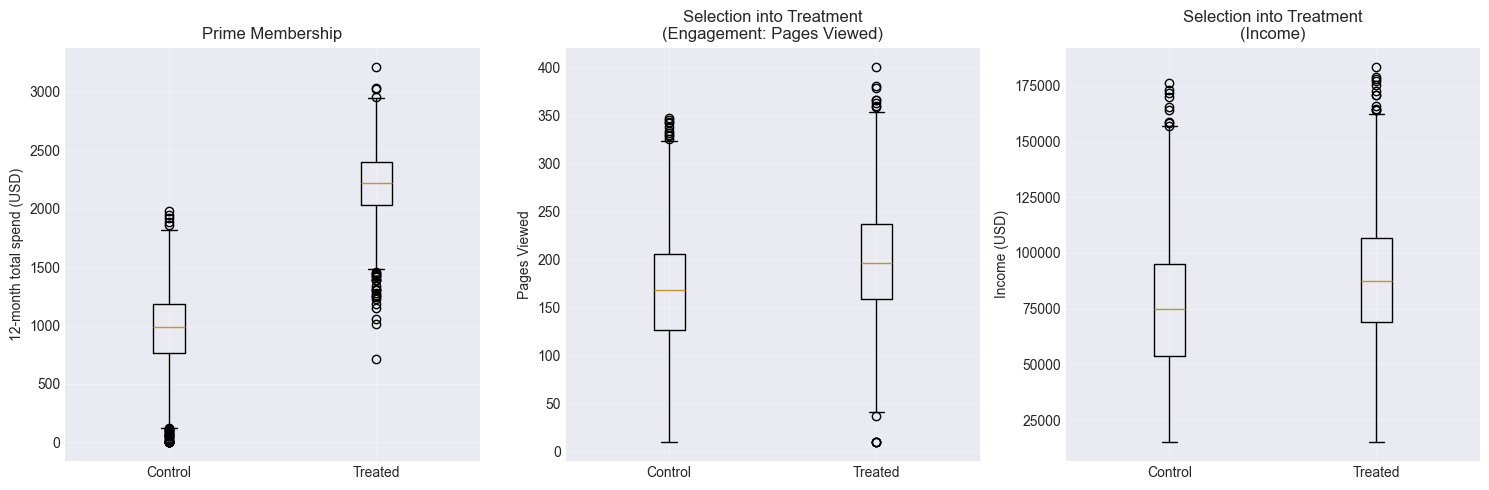

In [222]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1) Outcome by treatment (unchanged columns)
axes[0].boxplot(
    [df[df['treatment'] == 0]['outcome'],
     df[df['treatment'] == 1]['outcome']],
    labels=['Control', 'Treated']
)
axes[0].set_ylabel('12-month total spend (USD)')
axes[0].set_title('Prime Membership')
axes[0].grid(True, alpha=0.3)

# 2) Engagement confounder by treatment (replace pretest -> pages_viewed)
axes[1].boxplot(
    [df[df['treatment'] == 0]['pages_viewed'],
     df[df['treatment'] == 1]['pages_viewed']],
    labels=['Control', 'Treated']
)
axes[1].set_ylabel('Pages Viewed')
axes[1].set_title('Selection into Treatment\n(Engagement: Pages Viewed)')
axes[1].grid(True, alpha=0.3)

# 3) Income by treatment (replace fincome -> income)
axes[2].boxplot(
    [df[df['treatment'] == 0]['income'],
     df[df['treatment'] == 1]['income']],
    labels=['Control', 'Treated']
)
axes[2].set_ylabel('Income (USD)')
axes[2].set_title('Selection into Treatment\n(Income)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [223]:
# Calculate naive difference
naive_effect = df[df['treatment']==1]['outcome'].mean() - df[df['treatment']==0]['outcome'].mean()
print(f"\nNaive Treatment Effect (simple difference in means): {naive_effect:.3f} USD")
print("Note: This is likely biased due to confounding!")


Naive Treatment Effect (simple difference in means): 1248.259 USD
Note: This is likely biased due to confounding!


## 4. The Double Machine Learning Framework

### The Key Insight

DML estimates the treatment effect using a two-step procedure:

1. **First Stage**: Use ML to predict:
   - The outcome Y from confounders X (getting $\hat{Y}$)
   - The treatment D from confounders X (getting $\hat{D}$)

2. **Second Stage**: Regress the residuals:
   - $(Y - \hat{Y})$ on $(D - \hat{D})$
   
This "orthogonalizes" or "partials out" the confounders, isolating the treatment effect.

### Why "Double"?
- We use ML twice (for Y and D)
- We use cross-fitting to avoid overfitting bias



## 5. Implementing DML Step-by-Step

Let's implement DML with clear explanations at each step:

### Step 1: Prepare the Data

In [224]:
# Prepare our data arrays
X = df[confounder_vars].values  # Confounders
D = df[treatment_var].values    # Treatment
Y = df[outcome_var].values      # Outcome

In [225]:
# Standardize the features (helps ML models perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared:")
print(f"  X shape: {X.shape} (confounders)")
print(f"  D shape: {D.shape} (treatment)")
print(f"  Y shape: {Y.shape} (outcome)")

Data prepared:
  X shape: (5000, 24) (confounders)
  D shape: (5000,) (treatment)
  Y shape: (5000,) (outcome)


### Step 2: Set Up Cross-Fitting

Cross-fitting is crucial for DML. We'll split our data into 5 folds and use out-of-sample predictions to avoid overfitting:

In [226]:
# Set up cross-fitting with 5 folds
n_folds = 5
n_samples = len(Y)

# Initialize arrays to store residuals
residuals_Y = np.zeros(n_samples)  # Will store Y - predicted_Y
residuals_D = np.zeros(n_samples)  # Will store D - predicted_D

# Create fold indices for cross-fitting
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Cross-fitting setup:")
print(f"  Number of folds: {n_folds}")
print(f"  Samples per fold: ~{n_samples // n_folds}")
print(f"\nThis ensures we always use out-of-sample predictions!")

Cross-fitting setup:
  Number of folds: 5
  Samples per fold: ~1000

This ensures we always use out-of-sample predictions!


<!-- # %% [markdown]
# ### Step 3: Cross-Fitting Loop - The Heart of DML
# 
# For each fold, we'll:
# 1. Train ML models on 4 folds
# 2. Predict on the remaining fold (out-of-sample)
# 3. Calculate residuals

# %% -->

### Step 3: Cross-Fitting Loop - The Heart of DML

For each fold, we'll:
1. Train ML models on 4 folds
2. Predict on the remaining fold (out-of-sample)
3. Calculate residuals


In [227]:
for fold_num, (train_indices, test_indices) in enumerate(kfold.split(X_scaled), 1):
    
    print(f"\nFold {fold_num}/{n_folds}:")
    
    # Split data for this fold
    X_train = X_scaled[train_indices]
    X_test = X_scaled[test_indices]
    D_train = D[train_indices]
    D_test = D[test_indices]
    Y_train = Y[train_indices]
    Y_test = Y[test_indices]
    
    print(f"  Training on {len(train_indices)} samples")
    print(f"  Testing on {len(test_indices)} samples")
    
    # --- Model 1: Predict Y from X ---
    # Using Random Forest for flexibility
    model_Y = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=10,
        random_state=42
    )
    
    # Train and predict
    model_Y.fit(X_train, Y_train)
    Y_predictions = model_Y.predict(X_test)
    
    # Calculate residuals for Y (out-of-sample)
    residuals_Y[test_indices] = Y_test - Y_predictions
    
    print(f"  ✓ Y model trained and predicted")
    
    # --- Model 2: Predict D from X ---
    # Using Random Forest Classifier since D is binary
    model_D = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=10,
        random_state=42
    )
    
    # Train and predict (get probability of treatment)
    model_D.fit(X_train, D_train)
    D_predictions = model_D.predict_proba(X_test)[:, 1]  # Probability of D=1
    
    # Calculate residuals for D (out-of-sample)
    residuals_D[test_indices] = D_test - D_predictions
    
    print(f"  ✓ D model trained and predicted")

print("\n" + "=" * 50)
print("Cross-fitting complete! All residuals computed.")


Fold 1/5:
  Training on 4000 samples
  Testing on 1000 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 2/5:
  Training on 4000 samples
  Testing on 1000 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 3/5:
  Training on 4000 samples
  Testing on 1000 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 4/5:
  Training on 4000 samples
  Testing on 1000 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 5/5:
  Training on 4000 samples
  Testing on 1000 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Cross-fitting complete! All residuals computed.


### Step 4: Estimate the Treatment Effect from Residuals

Now we have:
- **residuals_Y**: The part of Y not explained by X
- **residuals_D**: The part of D not explained by X

The treatment effect is the relationship between these residuals:


**Calculate the Average Treatment Effect (ATE)**

This is the coefficient from regressing residuals_Y on residuals_D

In [228]:
# Method 1: Using the formula directly
numerator = np.sum(residuals_D * residuals_Y)
denominator = np.sum(residuals_D ** 2)
ate_dml = numerator / denominator

In [229]:
print("Treatment Effect Estimation:")
print("=" * 50)
print(f"Numerator (covariance):   {numerator:.4f}")
print(f"Denominator (variance):   {denominator:.4f}")
print(f"\nAverage Treatment Effect: {ate_dml:.4f} USD")

Treatment Effect Estimation:
Numerator (covariance):   1029280.5817
Denominator (variance):   1004.1343

Average Treatment Effect: 1025.0428 USD


In [230]:
# Method 2: Verify using linear regression (should give same result)
from sklearn.linear_model import LinearRegression
final_model = LinearRegression(fit_intercept=False)
final_model.fit(residuals_D.reshape(-1, 1), residuals_Y)
ate_verify = final_model.coef_[0]

In [231]:
print(f"Verification (via regression): {ate_verify:.4f} USD")
print("\n✓ Both methods give the same result!")

Verification (via regression): 1025.0428 USD

✓ Both methods give the same result!


### Step 5: Calculate Standard Errors for Statistical Inference

To know if our effect is statistically significant, we need standard errors:


In [232]:
# Calculate standard errors
n = len(residuals_Y)

# Residual variance from the final regression
final_residuals = residuals_Y - ate_dml * residuals_D
sigma_squared = np.sum(final_residuals ** 2) / (n - 1)

# Standard error of ATE
se_ate = np.sqrt(sigma_squared / np.sum(residuals_D ** 2))

# Calculate confidence interval
ci_lower = ate_dml - 1.96 * se_ate
ci_upper = ate_dml + 1.96 * se_ate

# Calculate t-statistic
t_statistic = ate_dml / se_ate

# Calculate p-value correctly using the t-distribution
from scipy import stats
# Degrees of freedom = n - 1 (we're estimating one parameter)
degrees_of_freedom = n - 1
# Two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), degrees_of_freedom))

print("Statistical Inference:")
print("=" * 50)
print(f"Standard Error:          {se_ate:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"t-statistic:            {t_statistic:.4f}")
print(f"p-value:                {p_value:.4f}")

Statistical Inference:
Standard Error:          7.4119
95% Confidence Interval: [1010.5154, 1039.5701]
t-statistic:            138.2966
p-value:                0.0000


In [233]:
if abs(t_statistic) > 1.96:
    print("\n✓ The effect is statistically significant at 5% level!")
else:
    print("\n✗ The effect is not statistically significant at 5% level")


✓ The effect is statistically significant at 5% level!


### Step 6: Visualize the Orthogonalized Relationship

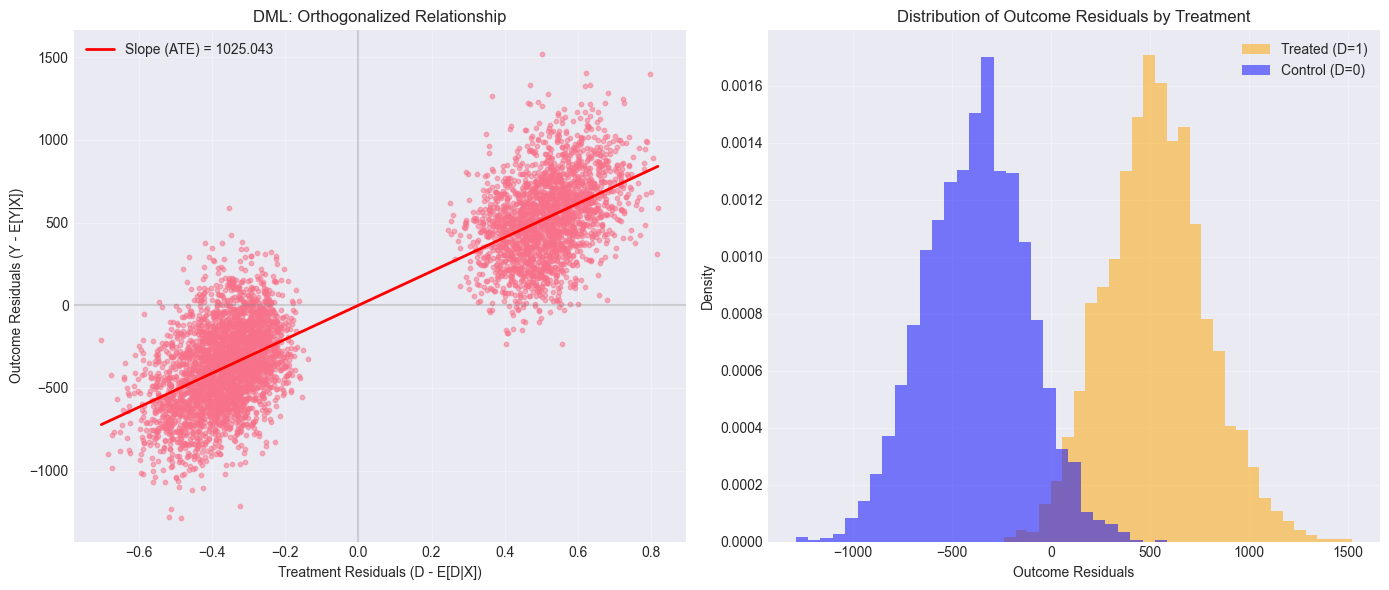

In [234]:
# Visualize the residuals and their relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Scatter of residuals
axes[0].scatter(residuals_D, residuals_Y, alpha=0.5, s=10)
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].axvline(x=0, color='gray', linestyle='-', alpha=0.3)

# Add regression line
x_line = np.linspace(residuals_D.min(), residuals_D.max(), 100)
y_line = ate_dml * x_line
axes[0].plot(x_line, y_line, 'r-', linewidth=2, 
             label=f'Slope (ATE) = {ate_dml:.3f}')

axes[0].set_xlabel('Treatment Residuals (D - E[D|X])')
axes[0].set_ylabel('Outcome Residuals (Y - E[Y|X])')
axes[0].set_title('DML: Orthogonalized Relationship')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of residuals
axes[1].hist(residuals_Y[residuals_D > 0], bins=30, alpha=0.5, 
             label='Treated (D=1)', density=True, color='orange')
axes[1].hist(residuals_Y[residuals_D < 0], bins=30, alpha=0.5, 
             label='Control (D=0)', density=True, color='blue')
axes[1].set_xlabel('Outcome Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Outcome Residuals by Treatment')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Compare Different ML Methods

Let's see how robust our results are by trying different ML algorithms:

### Using LASSO (Linear with Regularization)

In [235]:
# Reset residuals for LASSO
residuals_Y_lasso = np.zeros(n_samples)
residuals_D_lasso = np.zeros(n_samples)

print("Running DML with LASSO...")
print("=" * 50)

for fold_num, (train_indices, test_indices) in enumerate(kfold.split(X_scaled), 1):
    
    # Split data
    X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
    D_train, D_test = D[train_indices], D[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    
    # LASSO for Y
    model_Y_lasso = LassoCV(cv=5, random_state=42)
    model_Y_lasso.fit(X_train, Y_train)
    Y_pred_lasso = model_Y_lasso.predict(X_test)
    residuals_Y_lasso[test_indices] = Y_test - Y_pred_lasso
    
    # Logistic with L1 penalty for D
    model_D_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
    model_D_lasso.fit(X_train, D_train)
    D_pred_lasso = model_D_lasso.predict_proba(X_test)[:, 1]
    residuals_D_lasso[test_indices] = D_test - D_pred_lasso
    
    print(f"  Fold {fold_num} completed")

# Calculate ATE for LASSO
ate_lasso = np.sum(residuals_D_lasso * residuals_Y_lasso) / np.sum(residuals_D_lasso ** 2)

# Standard error for LASSO
final_residuals_lasso = residuals_Y_lasso - ate_lasso * residuals_D_lasso
sigma_squared_lasso = np.sum(final_residuals_lasso ** 2) / (n - 1)
se_lasso = np.sqrt(sigma_squared_lasso / np.sum(residuals_D_lasso ** 2))

print(f"\nLASSO Results:")
print(f"  ATE: {ate_lasso:.4f} (SE: {se_lasso:.4f})")
print(f"  95% CI: [{ate_lasso - 1.96*se_lasso:.4f}, {ate_lasso + 1.96*se_lasso:.4f}]")

Running DML with LASSO...
  Fold 1 completed
  Fold 2 completed
  Fold 3 completed
  Fold 4 completed
  Fold 5 completed

LASSO Results:
  ATE: 1016.5490 (SE: 6.8245)
  95% CI: [1003.1730, 1029.9251]


### Using Simple Linear Models (Baseline)

In [236]:
# Reset residuals for linear models
residuals_Y_linear = np.zeros(n_samples)
residuals_D_linear = np.zeros(n_samples)

print("Running DML with Linear Models...")
print("=" * 50)

for fold_num, (train_indices, test_indices) in enumerate(kfold.split(X_scaled), 1):
    
    # Split data
    X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
    D_train, D_test = D[train_indices], D[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    
    # Linear regression for Y
    model_Y_linear = LinearRegression()
    model_Y_linear.fit(X_train, Y_train)
    Y_pred_linear = model_Y_linear.predict(X_test)
    residuals_Y_linear[test_indices] = Y_test - Y_pred_linear
    
    # Logistic regression for D
    model_D_linear = LogisticRegression(random_state=42)
    model_D_linear.fit(X_train, D_train)
    D_pred_linear = model_D_linear.predict_proba(X_test)[:, 1]
    residuals_D_linear[test_indices] = D_test - D_pred_linear
    
    print(f"  Fold {fold_num} completed")

# Calculate ATE for linear models
ate_linear = np.sum(residuals_D_linear * residuals_Y_linear) / np.sum(residuals_D_linear ** 2)

# Standard error for linear
final_residuals_linear = residuals_Y_linear - ate_linear * residuals_D_linear
sigma_squared_linear = np.sum(final_residuals_linear ** 2) / (n - 1)
se_linear = np.sqrt(sigma_squared_linear / np.sum(residuals_D_linear ** 2))

print(f"\nLinear Model Results:")
print(f"  ATE: {ate_linear:.4f} (SE: {se_linear:.4f})")
print(f"  95% CI: [{ate_linear - 1.96*se_linear:.4f}, {ate_linear + 1.96*se_linear:.4f}]")

Running DML with Linear Models...
  Fold 1 completed
  Fold 2 completed
  Fold 3 completed
  Fold 4 completed
  Fold 5 completed

Linear Model Results:
  ATE: 1018.2442 (SE: 6.8007)
  95% CI: [1004.9148, 1031.5736]


## 7. Compare All Results


COMPARISON OF ALL METHODS
             Method  Treatment Effect  Standard Error  CI Lower  CI Upper
 Naive (No Control)         1248.2587             NaN       NaN       NaN
DML (Random Forest)         1025.0428          7.4119 1010.5154 1039.5701
        DML (LASSO)         1016.5490          6.8245 1003.1730 1029.9251
       DML (Linear)         1018.2442          6.8007 1004.9148 1031.5736


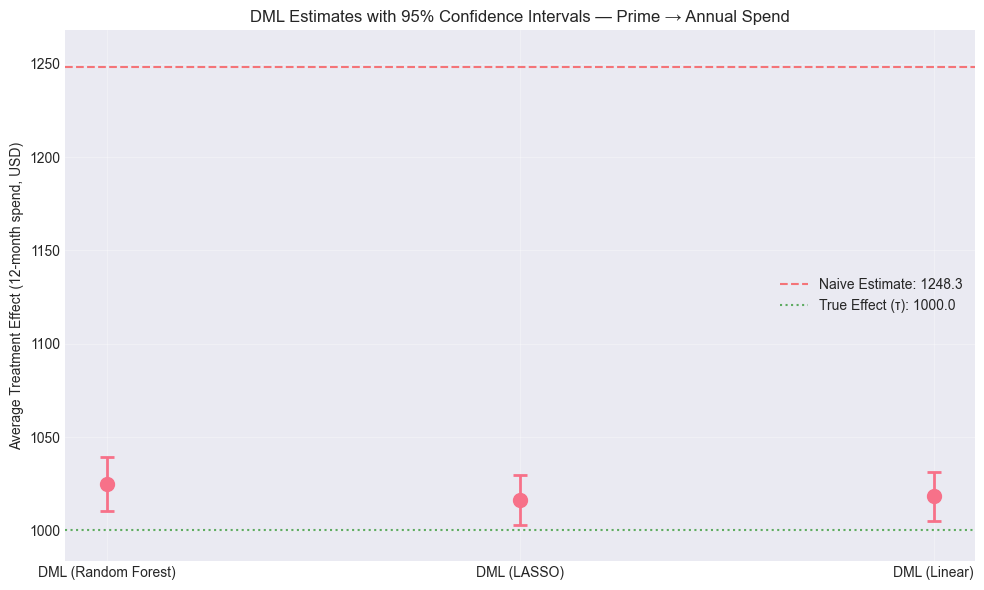

In [237]:
results_comparison = pd.DataFrame({
    'Method': ['Naive (No Control)', 'DML (Random Forest)', 'DML (LASSO)', 'DML (Linear)'],
    'Treatment Effect': [naive_effect, ate_dml, ate_lasso, ate_linear],
    'Standard Error': [np.nan, se_ate, se_lasso, se_linear],
    'CI Lower': [np.nan, ci_lower, ate_lasso - 1.96*se_lasso, ate_linear - 1.96*se_linear],
    'CI Upper': [np.nan, ci_upper, ate_lasso + 1.96*se_lasso, ate_linear + 1.96*se_linear]
})

print("\nCOMPARISON OF ALL METHODS")
print("=" * 70)
print(results_comparison.round(4).to_string(index=False))
print("=" * 70)

# Visualize comparison (zoom y-axis to the CI range around ~800)
fig, ax = plt.subplots(figsize=(10, 6))

methods = results_comparison['Method'].values[1:]   # exclude Naive for CI plotting
effects = results_comparison['Treatment Effect'].values[1:]
errors  = results_comparison['Standard Error'].values[1:]
ci_low  = results_comparison['CI Lower'].values[1:]
ci_high = results_comparison['CI Upper'].values[1:]

x_pos = np.arange(len(methods))
ax.errorbar(x_pos, effects, yerr=1.96*errors, fmt='o', capsize=5, capthick=2,
            markersize=10, linewidth=2)

# Reference lines
ax.axhline(y=naive_effect, color='red', linestyle='--', alpha=0.5, 
           label=f'Naive Estimate: {naive_effect:.1f}')
ax.axhline(y=tau, color='green', linestyle=':', alpha=0.6, label=f'True Effect (τ): {tau:.1f}')
y_min = np.nanmin(np.concatenate([ci_low, [naive_effect]]))
y_max = np.nanmax(np.concatenate([ci_high, [naive_effect]]))
pad = max(10.0, 0.08 * (y_max - y_min if (y_max - y_min) > 0 else 100.0))
ax.set_ylim(y_min - pad, y_max + pad)

ax.set_xticks(x_pos)
ax.set_xticklabels(methods, rotation=0)
ax.set_ylabel('Average Treatment Effect (12-month spend, USD)')
ax.set_title('DML Estimates with 95% Confidence Intervals — Prime → Annual Spend')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Interpretation of Results

In [238]:
print("=" * 70)
print("INTERPRETATION OF RESULTS")
print("=" * 70)

# Use Random Forest results as primary (most flexible)
primary_ate = ate_dml
primary_se = se_ate
primary_ci_lower = ci_lower
primary_ci_upper = ci_upper

print("\n1. MAIN FINDING:")
print(f"   Prime membership changes 12-month customer spend by ${primary_ate:,.2f}")
print(f"   95% Confidence Interval: [${primary_ci_lower:,.2f}, ${primary_ci_upper:,.2f}]")

print("\n2. BIAS CORRECTION:")
bias = naive_effect - primary_ate
print(f"   Naive estimate (no controls): ${naive_effect:,.2f}")
print(f"   DML estimate (controls via ML): ${primary_ate:,.2f}")
print(f"   Estimated selection bias: ${bias:,.2f}")
if abs(bias) > 0.1 * abs(primary_ate):
    print("   → Substantial confounding was present in the naive estimate!")
else:
    print("   → Limited confounding relative to the controlled estimate.")

print("\n3. STATISTICAL SIGNIFICANCE:")
t_stat = primary_ate / primary_se
if abs(t_stat) > 1.96:
    print(f"   ✓ The effect IS statistically significant (t={t_stat:.2f}, p<0.05)")
else:
    print(f"   ✗ The effect is NOT statistically significant (t={t_stat:.2f}, p>0.05)")

print("\n4. PRACTICAL SIGNIFICANCE:")
effect_size_pct = (primary_ate / df['outcome'].std()) * 100
print(f"   Effect size: {effect_size_pct:.1f}% of one standard deviation of annual spend")
if abs(effect_size_pct) >= 20:
    print("   → This represents a meaningful lift in annual customer spend.")
else:
    print("   → This is a modest change in practical terms.")

print("\n5. ROBUSTNESS:")
all_effects = [ate_dml, ate_lasso, ate_linear]
range_effects = max(all_effects) - min(all_effects)
if range_effects < 0.10 * abs(primary_ate):
    print("   ✓ Results are consistent across different ML learners (RF, LASSO, Linear).")
else:
    print("   ⚠ Results vary across learners—interpret with caution.")

print("=" * 70)


INTERPRETATION OF RESULTS

1. MAIN FINDING:
   Prime membership changes 12-month customer spend by $1,025.04
   95% Confidence Interval: [$1,010.52, $1,039.57]

2. BIAS CORRECTION:
   Naive estimate (no controls): $1,248.26
   DML estimate (controls via ML): $1,025.04
   Estimated selection bias: $223.22
   → Substantial confounding was present in the naive estimate!

3. STATISTICAL SIGNIFICANCE:
   ✓ The effect IS statistically significant (t=138.30, p<0.05)

4. PRACTICAL SIGNIFICANCE:
   Effect size: 149.0% of one standard deviation of annual spend
   → This represents a meaningful lift in annual customer spend.

5. ROBUSTNESS:
   ✓ Results are consistent across different ML learners (RF, LASSO, Linear).


## 9. Check Key Assumptions

### Overlap Assumption
We need treated and control units to be comparable (common support):

Checking Overlap Assumption...


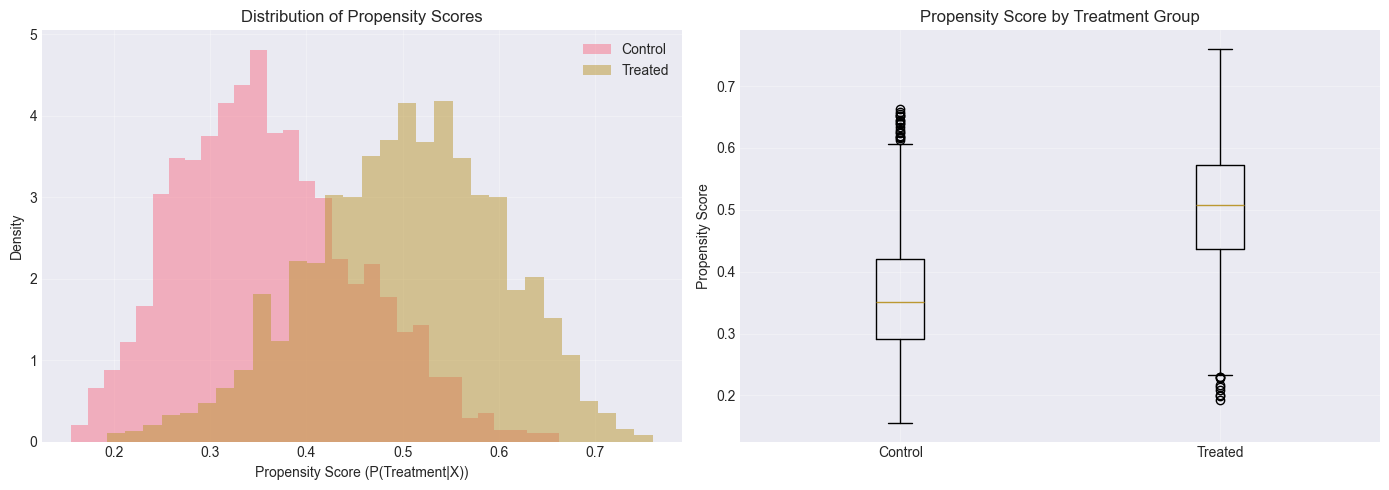

In [239]:
# Estimate propensity scores (probability of treatment given X)
from sklearn.ensemble import RandomForestClassifier

print("Checking Overlap Assumption...")
print("=" * 50)

# Fit propensity score model
ps_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
ps_model.fit(X_scaled, D)
propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]

# Visualize overlap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of propensity scores
axes[0].hist(propensity_scores[D==0], bins=30, alpha=0.5, label='Control', density=True)
axes[0].hist(propensity_scores[D==1], bins=30, alpha=0.5, label='Treated', density=True)
axes[0].set_xlabel('Propensity Score (P(Treatment|X))')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Propensity Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
axes[1].boxplot([propensity_scores[D==0], propensity_scores[D==1]], 
                labels=['Control', 'Treated'])
axes[1].set_ylabel('Propensity Score')
axes[1].set_title('Propensity Score by Treatment Group')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [240]:
# Check common support
common_support_region = (propensity_scores > 0.1) & (propensity_scores < 0.9)
pct_common_support = common_support_region.mean() * 100

print(f"\nOverlap Statistics:")
print(f"  Min propensity score: {propensity_scores.min():.3f}")
print(f"  Max propensity score: {propensity_scores.max():.3f}")
print(f"  % with good overlap (0.1 < P < 0.9): {pct_common_support:.1f}%")

if pct_common_support > 80:
    print("\n✓ Good overlap - comparison is valid!")
else:
    print("\n⚠ Limited overlap - results may be less reliable")


Overlap Statistics:
  Min propensity score: 0.156
  Max propensity score: 0.760
  % with good overlap (0.1 < P < 0.9): 100.0%

✓ Good overlap - comparison is valid!


## 10. Using Existing Libraries: DoubleML Package

While it's important to understand the mechanics of DML (as we've done above), in practice you can use established libraries that handle all the details for you.

The **DoubleML** package is the official Python implementation by the original DML authors.


In [241]:
# !pip install doubleml

In [242]:
import doubleml as dml
from doubleml import DoubleMLPLR

In [243]:
dml_data = dml.DoubleMLData(
        df,
        y_col='outcome',
        d_cols=['treatment'],
        x_cols=confounder_vars
    )

In [244]:
ml_l = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)  # For outcome
ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)  # For treatment

In [245]:
# Initialize the Double ML model
dml_plr = DoubleMLPLR(
        dml_data,
        ml_l=ml_l,
        ml_m=ml_m,
        n_folds=5,
        score='partialling out',  # The standard DML approach
        )

In [246]:
print("Fitting DoubleML model...")
dml_plr.fit()

Fitting DoubleML model...


In [247]:
print("\n" + "="*60)
print("DOUBLEML PACKAGE RESULTS:")
print("="*60)
print(dml_plr.summary)


DOUBLEML PACKAGE RESULTS:
                  coef   std err           t  P>|t|       2.5 %       97.5 %
treatment  1028.477164  7.577259  135.732094    0.0  1013.62601  1043.328318


In [248]:
# Extract values for comparison
package_ate = dml_plr.coef[0]
package_se = dml_plr.se[0]
package_pval = dml_plr.pval[0]
package_ci = dml_plr.confint()

print("\n" + "="*60)
print("COMPARISON: Manual vs Package Implementation")
print("="*60)
print(f"                     Manual DML    DoubleML Package")
print(f"                     ----------    ----------------")
print(f"ATE Estimate:        {ate_dml:8.4f}      {package_ate:8.4f}")
print(f"Standard Error:      {se_ate:8.4f}      {package_se:8.4f}")
print(f"95% CI Lower:        {ci_lower:8.4f}      {package_ci.iloc[0,0]:8.4f}")
print(f"95% CI Upper:        {ci_upper:8.4f}      {package_ci.iloc[0,1]:8.4f}")
print(f"P-value:             {p_value:8.4f}      {package_pval:8.4f}")
print("="*60)


COMPARISON: Manual vs Package Implementation
                     Manual DML    DoubleML Package
                     ----------    ----------------
ATE Estimate:        1025.0428      1028.4772
Standard Error:        7.4119        7.5773
95% CI Lower:        1010.5154      1013.6260
95% CI Upper:        1039.5701      1043.3283
P-value:               0.0000        0.0000


### Advantages of Using the DoubleML Package

The professional implementation offers several benefits:

1. **Validated Implementation**: Tested and maintained by the original authors
2. **Additional Features**: Bootstrap CIs, multiple treatments, sensitivity analysis
3. **Convenience**: Handles all the details automatically
4. **Speed**: Optimized implementation
5. **Documentation**: Extensive guides and examples

However, understanding the manual implementation (as we did above) is crucial for:
- Knowing what's happening "under the hood"
- Debugging when things go wrong
- Customizing for special cases
- Building intuition about the method

## 11. Pros and Cons of Double Machine Learning

### Advantages of DML:

1. FLEXIBILITY WITH ML METHODS  
   - Use any ML algorithm (RF, XGBoost, Neural Networks, etc.)  
   - Automatically handles non-linearities and interactions  
   - No need to specify functional forms
     

2. VALID STATISTICAL INFERENCE  
   - Provides correct standard errors and p-values  
   - Enables hypothesis testing despite using ML  
   - Confidence intervals have proper coverage  


3. HANDLES HIGH-DIMENSIONAL DATA  
   - Works with many confounders (p >> n scenarios)  
   - Automatic feature selection via regularization  
   - Reduces overfitting through cross-fitting  


4. ROBUST TO MODEL MISSPECIFICATION  
   - Less sensitive to wrong functional form assumptions  
   - Double robustness property in some cases  
   - Consistent under weaker conditions than OLS  


5. REDUCES REGULARIZATION BIAS  
   - Orthogonalization removes bias from ML regularization  
   - Neyman orthogonality ensures sqrt(n)-consistency  
   - Cross-fitting prevents overfitting bias  

---

### Limitations and Considerations:

1. SAMPLE SIZE REQUIREMENTS  
   - Needs relatively large samples (ideally n > 1000)  
   - Cross-fitting reduces effective sample size  
   - May be unstable with small samples  


2. COMPUTATIONAL COST  
   - More computationally intensive than OLS  
   - Requires fitting multiple ML models  
   - Cross-fitting multiplies computation time  


3. STILL REQUIRES KEY ASSUMPTIONS  
   - Unconfoundedness: All confounders must be measured  
   - Overlap: Treatment and control groups must be comparable  
   - SUTVA: No interference between units  
   - Cannot handle unobserved confounding  


4. MODEL SELECTION CHALLENGES  
   - Results can vary with ML method choice  
   - Hyperparameter tuning adds complexity  
   - No universal best ML approach  


5. INTERPRETABILITY  
   - Black-box ML models reduce interpretability  
   - Cannot easily see which variables matter most  
   - Harder to diagnose problems than with linear models  


6. LIMITED TO SPECIFIC PARAMETERS  
   - Primarily designed for average effects  
   - Extensions needed for other causal parameters  
   - Not all causal questions fit the DML framework


## 13. Resources for Further Learning

### Python Libraries for Causal ML

1. **DoubleML (Official DML Implementation)**
   - Install: `pip install doubleml`
   - Docs: https://docs.doubleml.org
   - Features: DML, GATE, ATE, sensitivity analysis

2. **EconML (Microsoft)**
   - Install: `pip install econml`
   - Docs: https://econml.azurewebsites.net/
   - Features: DML, Causal Forests, Meta-learners, IV methods

3. **CausalML (Uber)**
   - Install: `pip install causalml`
   - Docs: https://causalml.readthedocs.io/
   - Features: Uplift modeling, Meta-learners, Tree-based methods

4. **DoWhy (Microsoft/PyWhy)**
   - Install: `pip install dowhy`
   - Docs: https://py-why.github.io/dowhy/
   - Features: Causal graphs, identification, refutation tests

5. **CausalPy**
   - Install: `pip install causalpy`
   - Docs: https://github.com/pymc-labs/CausalPy
   - Features: Bayesian causal inference, synthetic controls

---

### Essential Readings for Double Machine Learning

#### Foundational Papers
1. Chernozhukov et al. (2018) — “Double/debiased machine learning for treatment and structural parameters”  
   - The original DML paper, essential reading  
   - https://arxiv.org/abs/1608.00060

2. Athey & Imbens (2019) — “Machine Learning Methods That Economists Should Know About”  
   - Excellent overview of ML in causal inference  
   - https://arxiv.org/abs/1903.10075

3. Belloni et al. (2014) — “Inference on Treatment Effects after Selection among High-Dimensional Controls”  
   - Foundation for using LASSO in causal inference  
   - https://arxiv.org/abs/1201.0224

#### Practical Guides
4. “User Guide for DoubleML”  
   - Step-by-step implementation guide  
   - https://docs.doubleml.org/stable/guide/guide.html

5. “Introduction to Double Machine Learning” (DoubleML Tutorial)  
   - Hands-on Python tutorial  
   - https://docs.doubleml.org/stable/intro/intro.html

#### Advanced Topics
6. Chernozhukov et al. (2022) — “Generic Machine Learning Inference on Heterogeneous Treatment Effects”  
   - Extension to heterogeneous effects  
   - https://arxiv.org/abs/1712.04802

7. Syrgkanis et al. (2019) — “Machine Learning Estimation of Heterogeneous Treatment Effects”  
   - EconML paper with practical algorithms  
   - https://arxiv.org/abs/1903.00140

#### Online Courses
8. “Machine Learning and Causal Inference” — Susan Athey (Stanford)  
   - Comprehensive course on ML + Causality

9. “Modern Topics in Causal Inference” — Various lectures on YouTube  
   - Search for talks by Chernozhukov, Athey, Imbens

#### Textbooks
10. “Causal Inference: The Mixtape” by Scott Cunningham  
    - Free online book with DML chapter  
    - https://mixtape.scunning.com/

11. “The Effect” by Nick Huntington-Klein  
    - Modern causal inference with code examples  
    - https://theeffectbook.net/


## 14. Further Exploration: Heterogeneous Effects (Advanced)

For those interested in diving deeper, here's how to explore heterogeneous treatment effects:
1. BY PRE-TEST SCORES:
   - Split sample by median pre-test score
   - Run DML separately for high/low performers
   - Compare if treatment helps one group more

2. BY DEMOGRAPHICS:
   - Analyze effects by gender, race, or income
   - Check if program has equitable impacts
   - Important for policy recommendations

3. BY GEOGRAPHY:
   - Urban vs rural effects
   - Distance to college effects
   - Regional variation in program impact
